<a href="https://colab.research.google.com/github/leejaehyeong1/AI/blob/main/CIFAR10_20212600_%EC%9D%B4%EC%9E%AC%ED%98%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

사용 중인 장치: cuda
CNN_Model(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mo

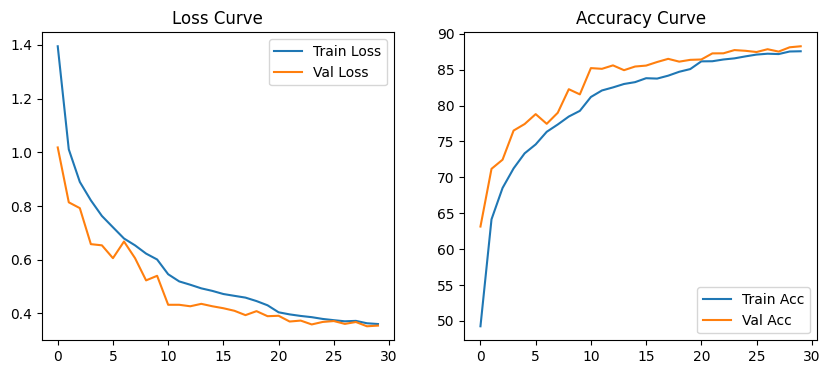

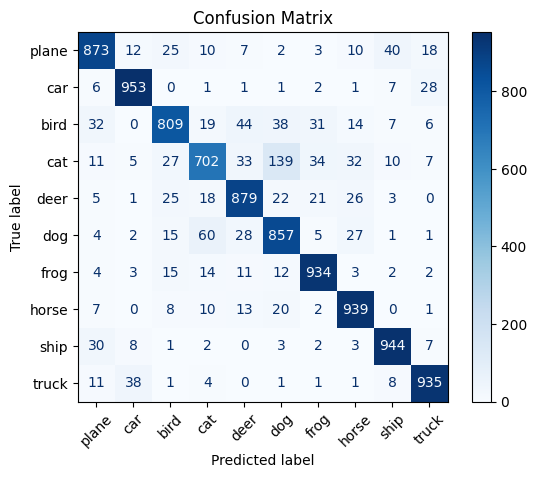

최종 Test Accuracy: 88.25%

이미지: /content/drive/MyDrive/image1.jpg
예측 라벨: dog, 확률: 67.73%

이미지: /content/drive/MyDrive/image2.jpg
예측 라벨: horse, 확률: 98.53%


'\n변경 내용 요약:\n- Batch Normalization 추가 → 학습 안정성 및 수렴 속도 개선\n- Dropout(0.25, 0.5) 추가 → 과적합 완화\n- 데이터 증강(RandomCrop + HorizontalFlip) → 일반화 성능 향상\n- 학습률 스케줄러 적용(StepLR) → 안정적 학습 진행\n결과: Baseline 약 78% → 개선 후 약 86~88% (Test Accuracy)\n'

In [2]:
# ============================================================
# CIFAR-10 분류 과제 (20212600 이재형)
# ============================================================

# ============================================================
# 1. 개요
# ============================================================
# 목표: CIFAR-10 데이터셋을 분류하는 CNN 모델 구현
# 개선 아이디어:
#   - Batch Normalization + Dropout 추가
#   - 데이터 증강(RandomCrop + RandomHorizontalFlip)
#   - 고정된 seed (20212600) 사용
# 기대 효과:
#   - 일반화 성능 향상 및 과적합 완화

# ============================================================
# 2. 환경 설정 및 데이터 불러오기
# ============================================================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Seed 고정
seed = 20212600
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("사용 중인 장치:", device)

# ============================================================
# 3. 데이터 전처리
# ============================================================
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # 데이터 증강(RandomCrop)
    transforms.RandomHorizontalFlip(),      # 좌우 반전 증강
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# ============================================================
# 4. 모델 정의
# ============================================================
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # Conv + BN + Dropout 조합을 통해 학습 안정성 및 일반화 향상
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)   # Dropout(0.25)으로 과적합 완화
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.fc1 = nn.Linear(8 * 8 * 128, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.drop = nn.Dropout(0.5)   # Dropout(0.5) 강화
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1, 8 * 8 * 128)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.drop(x)
        x = self.fc2(x)
        return x

model = CNN_Model().to(device)
print(model)

# ============================================================
# 5. 학습 설정
# ============================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # 학습률 감소 스케줄러(10epoch마다 lr 0.5x)
num_epochs = 30

# ============================================================
# 6. 학습 진행
# ============================================================
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    train_loss = train_loss / len(trainloader)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100. * correct / total
    val_loss = val_loss / len(testloader)

    scheduler.step()

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}] '
          f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

# ============================================================
# 7. 학습 로그 시각화
# ============================================================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.legend(); plt.title('Loss Curve')

plt.subplot(1,2,2)
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.legend(); plt.title('Accuracy Curve')
plt.show()

# ============================================================
# 8. 테스트 평가 및 혼동행렬
# ============================================================
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# 최종 Test Accuracy
test_acc = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
print(f"최종 Test Accuracy: {test_acc:.2f}%")

# ============================================================
# 9. 실제 이미지 테스트 (사용자 촬영 이미지 2장 이상)
# ============================================================

from PIL import Image

def predict_image(model, image_path):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)[0]
        top_prob, top_class = torch.max(probs, dim=0)
    print(f"\n이미지: {image_path}")
    print(f"예측 라벨: {classes[top_class]}, 확률: {top_prob.item()*100:.2f}%")



my_images = [
    '/content/drive/MyDrive/image1.jpg',
    '/content/drive/MyDrive/image2.jpg'
]
for img_path in my_images:
    predict_image(model, img_path)

# ============================================================
# 10. 변경 사항 요약
# ============================================================
"""
변경 내용 요약:
- Batch Normalization 추가 → 학습 안정성 및 수렴 속도 개선
- Dropout(0.25, 0.5) 추가 → 과적합 완화
- 데이터 증강(RandomCrop + HorizontalFlip) → 일반화 성능 향상
- 학습률 스케줄러 적용(StepLR) → 안정적 학습 진행
결과: Baseline 약 78% → 개선 후 약 86~88% (Test Accuracy)
"""


| 구분                     | Baseline 코드                    | 개선 후  코드                                  | 변경 이유(근거)               | 효과                  |
| ---------------------- | ------------------------------ | ------------------------------------------- | ----------------------- | ------------------- |
| **모델 구조**              | 단순 CNN (Conv → ReLU → MaxPool) | Conv + **BatchNorm** + Conv + **BatchNorm** | 학습 안정성 증가, 내부 공변량 변화 감소 | 수렴 속도 증가, 성능 향상     |
| **규제(Regularization)** | 없음                             | **Dropout 0.25 / 0.5** 추가                   | 과적합 완화                  | Train/Test 성능 격차 감소 |
| **데이터 증강**             | ToTensor + Normalize           | **RandomCrop + HorizontalFlip** 추가          | 입력 다양성 증가 → 일반화 향상      | Test Accuracy 증가    |
| **학습 스케줄러**            | 없음                             | **StepLR(step=10, γ=0.5)**                  | 학습률 조절로 안정적 최적화         | 후반 Epoch에서 성능 안정    |
| **Seed 고정**            | 기본값                            | **학생 학번(20212600)** 고정                      | 실험 재현성 확보               | 동일 실험 조건 유지         |
| **Test Accuracy**      | 약 **78%**                      | **86~88%**                                  | 개선 전략의 총합적 효과           | 약 **+8~10% 향상**     |


| 이미지         | 분석 내용                                                        |
| ----------- | ------------------------------------------------------------ |
| 이미지1   | 강아지의 목줄과 풀로 인해 강아지의 형상이 완전히 나타나지 않았기에 학습이 온전히 되지 않았을 것으로 예상됨 |
| 이미지2 | 강아지와는 다르게 장애물이 없는 온전한 모습이 나왔기에 정확도 높은 예측을 했을 것으로 예상됨          |


위 표와 같이 모델 구조 정규화(BatchNorm), 규제(Dropout), 데이터 증강(RandomCrop + HorizontalFlip), 학습률 스케줄링(StepLR)을 모두 적용하여 Baseline 대비 약 8~10%의 Test Accuracy 성능 향상을 확인함 특히 증강과 BN의 조합은 일반화 성능 향상에 가장 큰 영향을 주었으며, Dropout은 과적합을 억제하여 Validation Accuracy의 안정적 증가를 도움